In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

# **Initial Model**

In [8]:
class MusicGenRNN(nn.Module):
  def __init__(self, hidden_size=512, num_layers=1, bias=True):
    super(MusicGenRNN, self).__init__()
    # input # pitch, step and duration 
    # 128 is number of pitch possiblities
    self.one_hot_size = 128 + 2 # account for <BOS> and <EOS> this will be the second last and last features of the one hot
    self.pitch_embedding_size = 128 + 2
    self.hidden_size = hidden_size
    # size of embedding plus the 2 cts values step and duration
    self.input_size = self.pitch_embedding_size + 2 
    # size of discrete one hot plus the 2 cts values step and duration
    self.output_size = self.one_hot_size + 2

    # identiy matrix for generating one-hot vectors
    self.ident = torch.eye(self.one_hot_size).to(device)
    self.pitch_embedding = nn.Linear(self.one_hot_size, self.pitch_embedding_size, bias=False)

    #self.rnn = nn.LSTM(input_size, hidden_size, num_layers, bias, batch_first=True, dropout)
    self.rnn = nn.LSTM(self.input_size, hidden_size, num_layers, bias=bias, batch_first=True, dropout=0)
    # a fully-connect layer that outputs a distribution over the next token, given the RNN output
    self.decoder_pitch = nn.Linear(hidden_size, self.one_hot_size)
    self.decoder_step = nn.Linear(hidden_size, 1)
    self.decoder_duration = nn.Linear(hidden_size, 1)


  def forward(self, input, hidden_in=None):
    input = input.to(device)
    inp_pitch = input[:, :, 0]
    inp_step = input[:, :, 1]
    inp_duration = input[:, :, 2]
    inp_pitch = inp_pitch.long()
    # generate one-hot vector for discrete part of input
    one_hot_pitch = self.ident[inp_pitch].float()
    # embed the pitch to make it cts
    embedded_pitch = self.pitch_embedding(one_hot_pitch)
    # make inp = batch_size x sequence_length x 132
    inp = torch.concat((embedded_pitch, inp_step.reshape(*inp_step.shape, 1), inp_duration.reshape(*inp_duration.shape, 1)), dim=2)
    output, hidden_out = self.rnn(inp, hidden_in) # get the next output and hidden state
    output_pitch = self.decoder_pitch(output) # predict distribution over next tokens
    output_step = self.decoder_step(output) 
    output_duration = self.decoder_duration(output) 
    out = torch.concat((output_pitch, output_step.reshape(*inp_step.shape, 1), output_duration.reshape(*inp_duration.shape, 1)), dim=2)
    return out, hidden_out

# **Trainning Over Fitting**

In [3]:
import pickle
from google.colab import drive


drive.mount('/content/gdrive')
path_to_data = '/content/gdrive/My Drive/University/Year 4/CSC413/Project/data.pickle'

with open(path_to_data, 'rb') as f:
    dataset = pickle.load(f)

train_set, validation_set, test_set = dataset

print(train_set.shape)
#print(train_set[0])

# train contains N samples, of 64 length sequences, each sequence token is length 3.
# token in sequence is [pitch, step, duration]

Mounted at /content/gdrive
(3603, 64, 3)


In [10]:
def train(model, train_data, valid_data, batch_size=32, weight_decay=0.0,
           learning_rate=0.001, num_epochs=7, checkpoint_path=None):
  # get loss function, CE has softmax built in
  criterion_pitch = nn.CrossEntropyLoss()
  criterion_step = nn.MSELoss()
  criterion_duration = nn.MSELoss()
  # get optimizer
  optimizer = optim.Adam(model.parameters(),
                          lr=learning_rate,
                          weight_decay=weight_decay)
  # get dataloader, load training data
  train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True)
  # get val loader
  valid_loader = torch.utils.data.DataLoader(valid_data,
                                               batch_size=batch_size,
                                               shuffle=True)
  # learning curve information for plotting
  iters, iter_at_epoch, losses, train_acc, val_acc = [], [], [], [], []
  num_iters = 0
  # iterate the given number of epochs
  for epoch in range(num_epochs):
    # shuffling data done automatically by data loader
    for batch_of_sequences in iter(train_loader): # iterate through all data in loader
    # batch_of_sequences is of batch size
      # account for smaller last batch
      if batch_of_sequences.size()[0] < batch_size:
        continue
      # compute forward and backward pass
      model.train() # ensute model in train mode

      # add <BOS>=128 and <EOS>=129 terms, pitch values range 0-127 inclusive
      BOS = torch.tensor([128, 0.0, 0.0] * batch_size).reshape(batch_size, 1, 3)
      EOS = torch.tensor([129, 0.0, 0.0] * batch_size).reshape(batch_size, 1, 3)
      # input shape is batch_size x seqeunce_length=64+1 x token size = 3
      input = torch.concat((BOS, batch_of_sequences), dim=1) # <EOS> never input
      input = input.to(device)
      out, _ = model(input.float())
      # out = batch_size x sequence_size x 132 [0-129 pitch probs, 130 step, 131 duration]
      # 129 as it is the pitch tokens from 0-127 + 2 for <BOS> and <EOS>
      out_pitch = out[:, :, 0:130]
      out_step = out[:, :, 130]
      out_duration = out[:, :, 131]
      targets = torch.concat((batch_of_sequences, EOS), dim=1) # <BOS> never output
      targets = targets.float()
      targets = targets.to(device)
      targets_pitch = targets[:, :, 0]
      targets_step = targets[:, :, 1]
      targets_duration = targets[:, :, 2]
      # shape must be batch_size x # classes=130 x sequence_length
      loss_pitch = criterion_pitch(out_pitch.reshape(batch_size, -1, out_pitch.shape[1]), targets_pitch.long())
      loss_step = criterion_step(out_step, targets_step)
      loss_duration = criterion_duration(out_duration, targets_duration)
      total_loss = loss_pitch + loss_step + loss_duration 
      total_loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      # gather plotting data
      num_iters += 1
      losses.append(float(total_loss) / batch_size)
      iters.append(num_iters)

    # ------------VALIDATE ----------
    valid_losses , valid_iters = [], []
    for batch_of_sequences in iter(valid_loader): # iterate through all data in loader
    # batch_of_sequences is of batch size
      # account for smaller last batch
      if batch_of_sequences.size()[0] < batch_size:
        continue
      # compute forward and backward pass
      model.eval() # ensute model in train mode

      # add <BOS>=128 and <EOS>=129 terms, pitch values range 0-127 inclusive
      BOS = torch.tensor([128, 0.0, 0.0] * batch_size).reshape(batch_size, 1, 3)
      EOS = torch.tensor([129, 0.0, 0.0] * batch_size).reshape(batch_size, 1, 3)
      # input shape is batch_size x seqeunce_length=64+1 x token size = 3
      input = input.to(device)
      input = torch.concat((BOS, batch_of_sequences), dim=1) # <EOS> never input
      out, _ = model(input.float())
      # out = batch_size x sequence_size x 132 [0-129 pitch probs, 130 step, 131 duration]
      # 129 as it is the pitch tokens from 0-127 + 2 for <BOS> and <EOS>
      out_pitch = out[:, :, 0:130]
      out_step = out[:, :, 130]
      out_duration = out[:, :, 131]
      targets = torch.concat((batch_of_sequences, EOS), dim=1) # <BOS> never output
      targets = targets.float()
      targets = targets.to(device)
      targets_pitch = targets[:, :, 0]
      targets_step = targets[:, :, 1]
      targets_duration = targets[:, :, 2]
      # shape must be batch_size x # classes=130 x sequence_length
      loss_pitch = criterion_pitch(out_pitch.reshape(batch_size, -1, out_pitch.shape[1]), targets_pitch.long())
      loss_step = criterion_step(out_step, targets_step)
      loss_duration = criterion_duration(out_duration, targets_duration)
      valid_total_loss = loss_pitch + loss_step + loss_duration 
      # gather plotting data
      num_iters += 1
      valid_losses.append(float(valid_total_loss) / batch_size)
      valid_iters.append(num_iters)
    # --- epoch ended ---
    # # check point model
    # if (checkpoint_path is not None) and num_iters > 0:
    #   torch.save(model.state_dict(), checkpoint_path.format(num_iters))
    # # track learning curve info
    # iter_at_epoch.append(num_iters)
    # train_acc.append(get_accuracy(model, train_data))
    # val_acc.append(get_accuracy(model, valid_data))
    # # report accuracies on train and validation set
    print("Epoch %d. Iter %d. [Val Acc %.0f%%, Valid Loss %f] [Train Acc %.0f%%, Train Loss %f]" %
              (epoch, num_iters,0, float(valid_total_loss.cpu().detach().numpy()) ,0,float(total_loss.cpu().detach().numpy())))
      # print("Epoch %d. Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" % (epoch,
      #     num_iters, val_acc[-1] * 100, train_acc[-1] * 100, float(total_loss.detach().numpy())))
  return iters, losses, iter_at_epoch, train_acc, val_acc, valid_losses, valid_iters



def plot_learning_curve(iters, losses, iter_at_epoch, train_accs, val_accs, valid_losses, valid_iters):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    plt.title("Learning Curve: Valid Loss per Iteration")
    plt.plot(iters, losses, label="Valid")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iter_at_epoch, train_accs, label="Train")
    plt.plot(iter_at_epoch, val_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()


Epoch 0. Iter 2. [Val Acc 0%, Valid Loss 5.126576] [Train Acc 0%, Train Loss 5.259790]
Epoch 1. Iter 4. [Val Acc 0%, Valid Loss 5.079420] [Train Acc 0%, Train Loss 5.196311]
Epoch 2. Iter 6. [Val Acc 0%, Valid Loss 5.038402] [Train Acc 0%, Train Loss 5.139832]
Epoch 3. Iter 8. [Val Acc 0%, Valid Loss 5.055519] [Train Acc 0%, Train Loss 5.086934]
Epoch 4. Iter 10. [Val Acc 0%, Valid Loss 5.032860] [Train Acc 0%, Train Loss 5.088329]
Epoch 5. Iter 12. [Val Acc 0%, Valid Loss 5.029679] [Train Acc 0%, Train Loss 5.049192]
Epoch 6. Iter 14. [Val Acc 0%, Valid Loss 5.031931] [Train Acc 0%, Train Loss 5.033741]
Epoch 7. Iter 16. [Val Acc 0%, Valid Loss 5.033400] [Train Acc 0%, Train Loss 5.021895]
Epoch 8. Iter 18. [Val Acc 0%, Valid Loss 5.033764] [Train Acc 0%, Train Loss 5.004920]
Epoch 9. Iter 20. [Val Acc 0%, Valid Loss 5.036963] [Train Acc 0%, Train Loss 4.979620]
Epoch 10. Iter 22. [Val Acc 0%, Valid Loss 5.061860] [Train Acc 0%, Train Loss 4.944043]
Epoch 11. Iter 24. [Val Acc 0%, Val

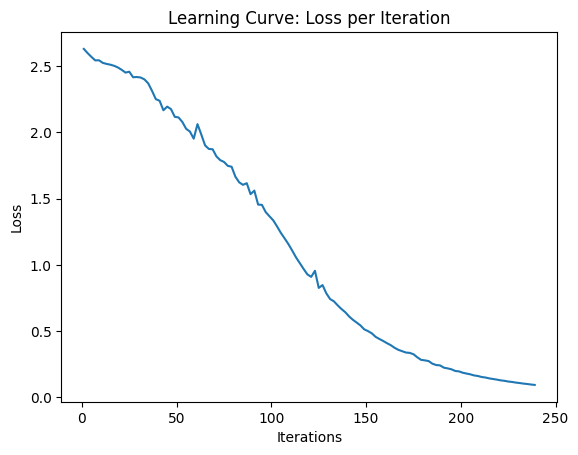

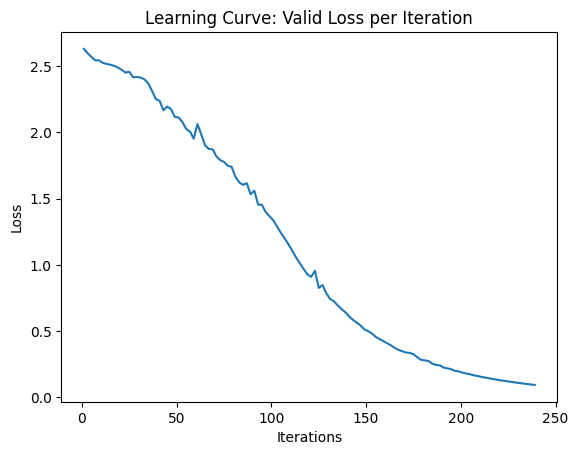

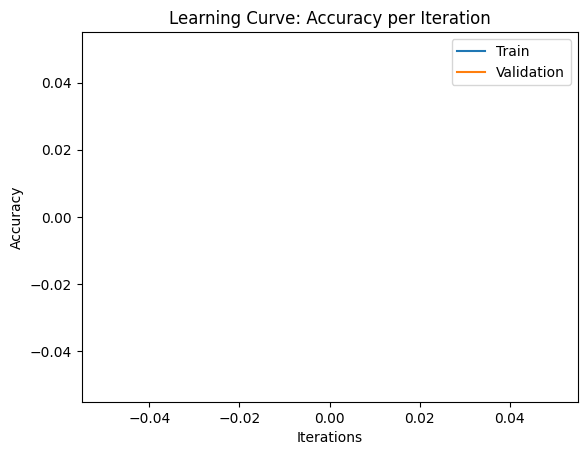

In [12]:
model = MusicGenRNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
plot_data = train(model, train_set[:2], validation_set[:2], num_epochs=120, batch_size=2)
plot_learning_curve(*plot_data)


# **Sampler**

In [36]:

def sample_sequence(model, max_len=100, temperature=0.8):
  generated_sequence = []
  inp = torch.tensor([128, 0.0, 0.0]).reshape(1, 3).to(device)
  hidden = None
  for p in range(max_len):
    output, hidden = model(inp.unsqueeze(0), hidden)
    out_pitch = output[0, 0, 0:130]
    out_step = output[0, 0, 130]
    out_duration = output[0, 0, 131]
    # Sample from the network as a multinomial distribution
    output_dist = out_pitch.data.view(-1).div(temperature).exp()
    top_i = int(torch.multinomial(output_dist, 1)[0])
    # Add predicted character to string and use as next input
    next_inp = torch.tensor([top_i, out_step, out_duration]).reshape(1, 3)
    generated_sequence.append([top_i, out_step, out_duration])
    if top_i == 129: break
    inp = next_inp
  return torch.tensor(generated_sequence)


In [37]:
gen_seq = sample_sequence(model, max_len=100, temperature=0.8)
print(gen_seq)



torch.Size([1, 3])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132])
torch.Size([1, 1, 132